In [ ]:
! nvidia-smi

Thu Jun 13 03:28:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Parameters
d = 300  # Dimension of x
B = 10  # Scalar constant B
n_samples_train = 50000  # Number of training samples
n_samples_test = 50000  # Number of testing samples
rho_train = 0.9  # Probability scalar for training
rho_test = 0.1  # Probability scalar for testing
epochs = 100  # Number of epochs
learning_rate = 0.01  # Learning rate

def generate_data(n_samples, d, B, rho, device="cpu"):
    y = torch.randint(0, 2, (n_samples,)) * 2 - 1
    z = torch.where(torch.rand(n_samples) < rho, y, -y)
    delta = torch.randn(n_samples, d - 2)
    z_scaled = B * z
    x = torch.cat([z_scaled.view(-1, 1), y.view(-1, 1), delta], dim=1)
    return x.to(device), y.to(device), z.to(device)

class LinearModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearModel, self).__init__()

        self.output = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.output(x)
        return x


# Define the logistic loss function
def logistic_loss(y, y_pred):
    return torch.log(1 + torch.exp(-y * y_pred)).mean()

cuda


In [ ]:
def get_grad(model, zero_grad=True):
    grad = []
    for n, p  in model.named_parameters():
        grad.append(p.grad.data.clone().flatten())
        if zero_grad:
            p.grad.zero_()
    return torch.cat(grad)

def set_grad(model, grad):
    total_length = 0
    for name, param in model.named_parameters():
        length = param.numel()
        param.grad.data = grad[
            total_length : total_length + length
        ].reshape(param.shape)
        total_length += length
    assert total_length == len(grad)
def get_param(model):
    param = []
    for n, p  in model.named_parameters():
        param.append(p.data.clone().flatten())
    return torch.cat(param)
def set_param(model, param):
    total_length = 0
    for n, p in model.named_parameters():
        length = p.numel()
        p.data = param[ total_length : total_length + length].data.reshape(p.shape)
        total_length += length
    assert total_length == len(param), f"{total_length}!={len(param)}"

In [ ]:
def run_erm(gradnorm, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    model = LinearModel(d)
    model = model.to(device)

    x_train, y_train, z_train = generate_data(n_samples_train, d, B, rho_train, device)
    x_val, y_val, z_val = x_train, y_train, z_train
    x_test, y_test, z_test = generate_data(n_samples_test, d, B, rho_test, device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    val_losses = []
    test_losses = []
    val_accuracies = []
    test_accuracies = []
    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        param = get_param(model)


        y_pred = model(x_train).squeeze()
        loss = logistic_loss(y_train, y_pred)
        loss.backward()
        grad = get_grad(model)
        new_param = param + gradnorm * grad/(torch.norm(grad) + 1e-12)

        set_param(model, new_param)
        y_pred = model(x_train).squeeze()
        loss = logistic_loss(y_train, y_pred)
        loss.backward()
        set_param(model, param)
        optimizer.step()


        model.eval()
        with torch.no_grad():
            y_pred_val = model(x_val).squeeze()
            val_loss = logistic_loss(y_val, y_pred_val)
            y_pred_val_labels = torch.sign(y_pred_val)
            val_acc = (y_pred_val_labels == y_val).float().mean()

            y_pred_test = model(x_test).squeeze()
            test_loss = logistic_loss(y_test, y_pred_test)
            y_pred_test_labels = torch.sign(y_pred_test)
            test_acc = (y_pred_test_labels == y_test).float().mean()

            val_losses.append(val_loss.item())
            test_losses.append(test_loss.item())
            val_accuracies.append(val_acc.item())
            test_accuracies.append(test_acc.item())

    return {
        "val_losses": val_losses,
        "test_losses": test_losses,
        "val_accuracies": val_accuracies,
        "test_accuracies": test_accuracies
    }



In [ ]:
def run(gradnorm, align, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    model = LinearModel(d)
    model = model.to(device)

    x_train, y_train, z_train = generate_data(n_samples_train, d, B, rho_train, device)
    x_val, y_val, z_val = x_train, y_train, z_train
    x_test, y_test, z_test = generate_data(n_samples_test, d, B, rho_test, device)

    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    x1 = x_train[z_train == 1]
    x2 = x_train[z_train == -1]
    y1 = y_train[z_train == 1]
    y2 = y_train[z_train == -1]

    val_losses = []
    test_losses = []
    val_accuracies = []
    test_accuracies = []


    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        param = get_param(model)

        y_pred1 = model(x1).squeeze()
        loss = logistic_loss(y1, y_pred1)
        loss.backward()
        grad1 = get_grad(model)

        y_pred2 = model(x2).squeeze()
        loss = logistic_loss(y2, y_pred2)
        loss.backward()
        grad2 = get_grad(model)

        param1 = param + gradnorm * grad1/(torch.norm(grad1) + 1e-12) - align * grad2/(torch.norm(grad2)*torch.norm(grad1) + 1e-12)
        set_param(model, param1)

        y_pred1 = model(x1).squeeze()
        loss = logistic_loss(y1, y_pred1)
        loss.backward()
        new_grad1 = get_grad(model)


        param2 = param + gradnorm * grad2/(torch.norm(grad2) + 1e-12) - align * grad1/(torch.norm(grad2)*torch.norm(grad1) + 1e-12)
        set_param(model, param2)

        y_pred2 = model(x2).squeeze()
        loss = logistic_loss(y2, y_pred2)
        loss.backward()
        new_grad2 = get_grad(model)

        set_grad(model, new_grad1 + new_grad2)
        optimizer.step()


        model.eval()
        with torch.no_grad():
            y_pred_val = model(x_val).squeeze()
            val_loss = logistic_loss(y_val, y_pred_val)
            y_pred_val_labels = torch.sign(y_pred_val)
            val_acc = (y_pred_val_labels == y_val).float().mean()

            y_pred_test = model(x_test).squeeze()
            test_loss = logistic_loss(y_test, y_pred_test)
            y_pred_test_labels = torch.sign(y_pred_test)
            test_acc = (y_pred_test_labels == y_test).float().mean()

            val_losses.append(val_loss.item())
            test_losses.append(test_loss.item())
            val_accuracies.append(val_acc.item())
            test_accuracies.append(test_acc.item())

    return {
        "val_losses": val_losses,
        "test_losses": test_losses,
        "val_accuracies": val_accuracies,
        "test_accuracies": test_accuracies
    }


In [ ]:
import matplotlib.pyplot as plt

def plot(metrics):
    epochs = list(range(1, 101))  # Assuming 100 epochs

    # Plot validation and test losses
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.errorbar(epochs, metrics['val_losses_mean'], yerr=metrics['val_losses_std'], label='Validation Loss', fmt='-o', capsize=5)
    plt.errorbar(epochs, metrics['test_losses_mean'], yerr=metrics['test_losses_std'], label='Test Loss', fmt='-o', capsize=5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation and Test Loss')
    plt.legend()
    plt.grid(True)

    # Plot validation and test accuracies
    plt.subplot(1, 2, 2)
    plt.errorbar(epochs, metrics['val_accuracies_mean'], yerr=metrics['val_accuracies_std'], label='Validation Accuracy', fmt='-o', capsize=5)
    plt.errorbar(epochs, metrics['test_accuracies_mean'], yerr=metrics['test_accuracies_std'], label='Test Accuracy', fmt='-o', capsize=5)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation and Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
n_seeds = 10
metrics = []

for seed in range(1, 1+ n_seeds):
    metrics.append(run_erm(.0, seed))
erm_result = dict()
for k, v in metrics[0].items():
    erm_result[k+'_mean'] = np.mean(np.stack([metric[k] for metric in metrics]), axis=0)
    erm_result[k+'_std'] = np.std(np.stack([metric[k] for metric in metrics]), axis=0)/np.sqrt(n_seeds)
plot(erm_result)

In [ ]:
n_seeds = 10
metrics = []

for seed in range(1, 1+ n_seeds):
    metrics.append(run_erm(.01, seed))
gradnorm_result = dict()
for k, v in metrics[0].items():
    gradnorm_result[k+'_mean'] = np.mean(np.stack([metric[k] for metric in metrics]), axis=0)
    gradnorm_result[k+'_std'] = np.std(np.stack([metric[k] for metric in metrics]), axis=0)/np.sqrt(n_seeds)
plot(gradnorm_result)

In [ ]:
n_seeds = 10
metrics = []

for seed in range(1, 1+ n_seeds):
    metrics.append(run(0.0, 0.01, seed))
align_result = dict()
for k, v in metrics[0].items():
    align_result[k+'_mean'] = np.mean(np.stack([metric[k] for metric in metrics]), axis=0)
    align_result[k+'_std'] = np.std(np.stack([metric[k] for metric in metrics]), axis=0)/np.sqrt(n_seeds)
plot(align_result)

In [ ]:
n_seeds = 10
metrics = []

for seed in range(1, 1+ n_seeds):
    metrics.append(run(0.005, 0.01, seed))
our_result = dict()
for k, v in metrics[0].items():
    our_result[k+'_mean'] = np.mean(np.stack([metric[k] for metric in metrics]), axis=0)
    our_result[k+'_std'] = np.std(np.stack([metric[k] for metric in metrics]), axis=0)/np.sqrt(n_seeds)
plot(our_result)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example dictionaries with keys containing lists of 100 numbers
metrics_1 = erm_result
metrics_2 = our_result

epochs = list(range(1, 101))  # Assuming 100 epochs

# Plot validation and test accuracies for both results
plt.figure(figsize=(8, 4))

# Plot accuracies for the first set of metrics
plt.plot(epochs, 100*metrics_1['val_accuracies_mean'], label='In-distribution (ERM)', linestyle='--', color="blue")
plt.plot(epochs, 100*metrics_1['test_accuracies_mean'], label='Out-of-distribution (ERM)', linestyle='-', color="blue")

# Plot accuracies for the second set of metrics
plt.plot(epochs, 100*metrics_2['val_accuracies_mean'], label='In-distributionn (Ours)', linestyle='--', color="green")
plt.plot(epochs, 100*metrics_2['test_accuracies_mean'], label='Out-of-distribution (Ours)', linestyle='-', color="green")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

In [ ]:
! pip install SciencePlots

In [ ]:
import scienceplots

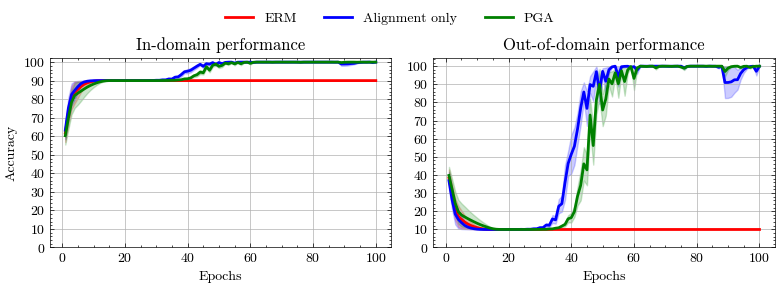

In [ ]:
with plt.style.context(['science', 'no-latex']):

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

    metrics_1 = erm_result
    metrics_2 = align_result
    metrics_3 = our_result
    # Plot validation accuracies for both models
    line1=ax1.plot(epochs,100*metrics_1['val_accuracies_mean'], label='ERM', color="red",linewidth=2.0)
    line2=ax1.plot(epochs, 100*metrics_2['val_accuracies_mean'], label='Alignment only', color="blue",linewidth=2.0)
    line3=ax1.plot(epochs, 100*metrics_3['val_accuracies_mean'], label='PGA', color="green",linewidth=2.0)

    # Plot validation accuracies for both models
    ax1.fill_between(epochs, 100*(np.array(metrics_1['val_accuracies_mean']) - np.array(metrics_1['val_accuracies_std'])),
                    100*(np.array(metrics_1['val_accuracies_mean']) + np.array(metrics_1['val_accuracies_std'])), alpha=0.2, color="red")

    ax1.fill_between(epochs, 100*(np.array(metrics_2['val_accuracies_mean']) - np.array(metrics_2['val_accuracies_std'])),
                    100*(np.array(metrics_2['val_accuracies_mean']) + np.array(metrics_2['val_accuracies_std'])), alpha=0.2, color="blue")

    ax1.fill_between(epochs, 100*(np.array(metrics_3['val_accuracies_mean']) - np.array(metrics_3['val_accuracies_std'])),
                    100*(np.array(metrics_3['val_accuracies_mean']) + np.array(metrics_3['val_accuracies_std'])), alpha=0.2, color="green")


    ax1.set_xlabel('Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('In-domain performance')
    ax1.grid()
    ax1.set_yticks(np.arange(0, 110, 10))

    # Plot test accuracies for both models
    ax2.plot(epochs, 100*metrics_1['test_accuracies_mean'], color="red",linewidth=2.0)
    ax2.plot(epochs, 100*metrics_2['test_accuracies_mean'], color="blue",linewidth=2.0)
    ax2.plot(epochs, 100*metrics_3['test_accuracies_mean'], color="green",linewidth=2.0)
    ax2.fill_between(epochs, 100*(np.array(metrics_1['test_accuracies_mean']) - np.array(metrics_1['test_accuracies_std'])),
                    100*(np.array(metrics_1['test_accuracies_mean']) + np.array(metrics_1['test_accuracies_std'])), alpha=0.2, color="red")

    ax2.fill_between(epochs, 100*(np.array(metrics_2['test_accuracies_mean']) - np.array(metrics_2['test_accuracies_std'])),
                    100*(np.array(metrics_2['test_accuracies_mean']) + np.array(metrics_2['test_accuracies_std'])), alpha=0.2, color="blue")
    ax2.fill_between(epochs, 100*(np.array(metrics_3['test_accuracies_mean']) - np.array(metrics_3['test_accuracies_std'])),
                    100*(np.array(metrics_3['test_accuracies_mean']) + np.array(metrics_3['test_accuracies_std'])), alpha=0.2, color="green")
    ax2.set_xlabel('Epochs')

    ax2.set_xlabel('Epochs')
    ax2.set_title('Out-of-domain performance')
    ax2.grid()
    ax2.set_yticks(np.arange(0, 110, 10))
    lines, labels = [], []

    line, label = ax1.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)


    fig.legend(lines, labels, loc='upper center', ncol=3)

    plt.tight_layout()
    plt.subplots_adjust(top=.8)
    plt.savefig("toy.pdf")
    plt.show()